## <span style="color:red">Motivation</span>

# The Story of Hollywood - Hollywood as a voice of the times and the cliques that lie within it's top
People have throughout history always look for ways to express themselves through art and since the invention of the Kinetograph, which was the first motion picture camera, by Thomas Edison and his British assistant William Dickson 1890 [1](https://www.pbs.org/wgbh/americanexperience/features/pickford-early-history-motion-pictures/#:~:text=In%201888%20in%20New%20York,a%20primitive%20motion%20picture%20camera.), motion pictures have become increasingly popular. In 2020 the box-office revenue in the US alone was USD $11.300.000$

Skriv noget mere

### Data
Almost everyone have a strong relationship to movies, the intrigue, enlighten, make you cry and make you laugh. We wanted to know more about the structure of the largest productions of them all, and that is why the project evolves around the [tmdb 5000](https://www.kaggle.com/tmdb/tmdb-movie-metadata) dataset. This dataset contains data on the plot, cast, crew, budget, and revenues of several thousand films, but have the advantage that the data is already filtered and cleaned. We choose this dataset as is provides a good foundation of our analysis, but other data sources will also in the report to verify and support the findings.


### Goal of the project
The overall idea of this project is to investigate interesting properties of Hollywood acting environment and how it has developed over time? As the dataset contains a lot of information, these properties have split into two major areas of focus. 
* Movies as a Voice of the times and the Evolution of Hollywood itself
* Hollywood as a closed community structue, with few Actors working alot together. Furthermore, that these communities also exsist outside the set of the movies

There are of course many more interesting elements to look at, kaggle suggests looking at "... the success of a movie before it is released?", or "Are there certain companies (Pixar?) that have found a consistent formula?", but our goal is that after having read this notebook, one would have gotten an in depth understanding of **hollywood as a voice of the times** and **the closed community structure of it**


NOTE: also that the reader experiance some beautifull plots 


## <span style="color:red">Basic stats</span>
<span style="color:red">Data processing and cleaning</span>

<span style="color:red">Introduction to datasets</span>

## Basic stats of the Data and network

This section will present some basic information about the dataset and initial preperation to allow for the reader to get a good idea abouyt the data the project is working with

In [126]:
#Imports
from IPython.display import Image, clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import re
import nltk
import json
import bar_chart_race as bcr
import random
from fa2 import ForceAtlas2
import json
from collections import Counter, defaultdict
import urllib
from datetime import datetime
from ipywidgets import *
import ipywidgets as widgets
import time
import math
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import seaborn as sns
import gif


#Init stopwords
stop_words = set(stopwords.words('english'))

### IMDB 5000

WHAT IS THE DATA ETC: WRITE MORE

In [4]:
# Datasets
RELATIVE_FILE_PATH=r'C:\Users\bilto\OneDrive\Uddannelse\Skole\DTU\02805 - Sociale Grafer og interaktioner\Afleveringer\\'
movies = pd.read_csv(RELATIVE_FILE_PATH+'tmdb_5000_movies.csv')
credits = pd.read_csv(RELATIVE_FILE_PATH + 'tmdb_5000_credits.csv')

In [5]:
# Creating DF
df = movies.merge(right = credits, left_on = 'id', right_on = 'movie_id')
df['release_date'] = pd.to_datetime(df['release_date'])


#Convert JSON to dict and extract the names of each actor in each movie
actors_per_movie = df['cast'].apply(lambda x: ','.join([y['name'] for y in json.loads(x)])).str.split(',', expand = True).fillna('')
actors_per_movie = df[['original_title', 'id']].merge(right = actors_per_movie, left_index = True, right_index = True)

#Unpivot
actors_per_movie = actors_per_movie.melt(id_vars=['original_title', 'id'])

#Remove empty rows
actors_per_movie = actors_per_movie[actors_per_movie['value'] != '']

#Number of movies per actor
pt = actors_per_movie.pivot_table(index = 'value', values='id', aggfunc = len).reset_index().sort_values(by='id', ascending = False).reset_index()

In [8]:
pt.head()

,index,value,id
0,45586,Samuel L. Jackson,67
1,2,Jr.,60
2,43599,Robert De Niro,57
3,6819,Bruce Willis,51
4,34677,Matt Damon,48


In [9]:
print(f"In the original {len(df)} movies, there are {len(pt)} actors. Of these actors {len(pt[pt['id']<5])} have starred in less than 5 movies")

In the original 4803 movies, there are 54199 actors. Of these actors 50394 have starred in less than 5 movies


#### Decreasing the size of the data

We now have the full dataset, but as we can see above there are quite Actors in this network that contribute very little information to the questions we want to answer. Modelling the network with actors as nodes and movies as the links between them we will have alot of low degree nodes potentially disturbing the picture.
Many of these low degree actors are most likely extras, but since there are only 4803 movies in the data and as of 2012 the United States has produced roughly 44.000 [movies](https://babelniche.com/2013/06/29/where-are-movies-made/) according to IMDB. 

Due to this, and also to reduce the complexity we have decided to only look at the top 500 most productive actors and actresses

In [10]:
#Select top N actors by number of movies
pt = pt.nlargest(500, 'id')
#Top N actors as Nodes
nodes = pt['value'].tolist()

#### The Network itself
As mentioned the network will consist of actors as nodes and movies as edges. Of course actors can participate in multiple movies together, and this is also part of our investigation. To handle this we will model the network as a weighted undirected graph where the weight is the number of movies the actors starred together in.

The network is also going to contain some other basic stats on nodes and edges:

**Edges**
* Weight
* Movie id list ( NOT IMPLEMENTED)

**Nodes**
* Name of actor/actress
* Movie id list
* Genre dictionary

The reason we only store the id's and not the full data is to reduce redundance and while not decreasing speed

In [11]:
# Creating the network

# Extracting genre
movie_genre={}
for x in movies.iterrows():
    movie_genre[x[1]['original_title']]=[y['name'] for y in json.loads(x[1]['genres'])]

    
#Create edges between actors that have been in the same movie
edges = []
actor_genre = {}
actor_movies_count = {}
actor_movies_list = {}
edge_movie_lookup = {}
for node in nodes:
    actor_movies = actors_per_movie[actors_per_movie['value'] == node]['original_title'].tolist()
    edges += [(node, x) for x in\
              actors_per_movie[(actors_per_movie['original_title'].isin(actor_movies)) \
                & (actors_per_movie['value'].isin(nodes))]['value'] if node != x]

    # Actor
    cnt=len(actor_movies)
    actor_movies_count[node] = cnt
    actor_movies_list[node] = actor_movies
    actor_genre[node]=[movie_genre[y] for y in actor_movies]


In [12]:
# Init graph
G = nx.Graph()

# Add nodes and edges
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [13]:
# Set attributes

ct=Counter(edges)
# Add weights
for key, value in ct.items():
    G.edges[key]['weight'] = value
    
# Generate list of movies for edges
for key, value in edge_movie_lookup.items():
    G.edges[key]['movies']=value

# Add most frequent genre
for actor in G.nodes:
    G.nodes[actor]['genre']=Counter([x for y in actor_genre[actor] for x in y])
    G.nodes[actor]['top_genre']=G.nodes[actor]['genre'].most_common(1)[0][0]
    G.nodes[actor]['top_genre']
    G.nodes[actor]['movies_count']=actor_movies_count[actor]
    G.nodes[actor]['movies']=actor_movies_list[actor]

In [14]:
# Taking a look at a node in the graph
print(actor)
for x in G.nodes[actor]:
    print (f"{x}:",G.nodes[actor][x])

Elisabeth Shue
genre: Counter({'Drama': 8, 'Comedy': 7, 'Thriller': 5, 'Romance': 4, 'Science Fiction': 4, 'Horror': 3, 'Adventure': 3, 'Family': 3, 'Action': 2, 'Mystery': 2, 'Crime': 1, 'Music': 1})
top_genre: Drama
movies_count: 17
movies: ['Piranha 3D', 'Molly', 'Hollow Man', 'The Saint', 'Don McKay', 'Leaving Las Vegas', 'Chasing Mavericks', 'House at the End of the Street', 'Back to the Future Part II', 'Dreamer: Inspired By a True Story', 'Hide and Seek', 'Back to the Future Part III', 'The Karate Kid', 'Deconstructing Harry', 'Gracie', 'Hamlet 2', 'Hope Springs']


### WIKIPEDIA YEAR LOOKUP

The second part of the dataset is a lookup of an the year/decades wikipedia page to see if the findings from our analysis corresponds to the sentiment found on the pages. The purpose and hypotesis of this is that we will find a direct correlation between the sentiment of movies and the sorrunding decands data.

One assumption here is that will let the production of hollywood reflect the general state of the world. The reason for this is that there is no pattern wikipedia pattern for year/decade lookup only for the us. Scraping multiple sites will take too much time and loose focus of the important stuff. A reason why this assumption might be allright is due to the fact that the earlies movies in the dataset start around 1970's, which means that society is quite globalised already

**Cleaning and preprocessing**
The data is fetched through the api and is parsed using regex to a raw but filtered state

The filtering applied is:
* Removing links an references to other pages identified by being within <> or {}
* Removing links identified by starting with url=
* Removing non alpha numeric charaters
* Removing links identified by starting with http

This leaves us some partly filtered data still containing stopwords etc. ready for analysis

In [15]:
#The content of the characters' wiki-pages is extracted using the wikipedia API
baseurl = 'https://en.wikipedia.org/w/api.php?'
action = 'action=query'
title = 'titles='
content = 'prop=revisions&rvprop=content'
dataformat = 'format=json'

def look_up_decade(year: int)-> str:
    decade_start=int(year/10)*10
    query = '%s%s&%s&%s&%s' % (baseurl,action,f'titles={decade_start}s',content,dataformat)
    res = json.loads(urllib.request.urlopen(query).read().decode('utf-8'))
    pages = res.get('query').get('pages')
    if not pages:
        raise Exception('No pages found')
    data = []
    for page in pages.keys():
        try:
            data.append(res['query']['pages'][page]['revisions'][0]['*'])
        except:
            print(f"Failed on pages{page}")
    return data

def process_data(d:list, limit=3)->list:
    data_string = ''
    temp_str = ''
    
    i=0
    for x in d:
        if i>=limit:
            break
        # Remove special chars and data in links
        temp_str=re.sub("[\{\<.*?[\}\>]", "", x)
        # Remove links
        temp_str=re.sub('url=.\S*','',temp_str)
        # Weird chars
        temp_str=re.sub('[^a-zA-Z0-9 \n\.]', '', temp_str)
        # Remaning links
        temp_str=re.sub('http.\S*','',re.sub('[^a-zA-Z0-9 \n\.]', '', temp_str))
        # Remaning links
        temp_str=re.sub('redirect.\S*','',temp_str)
        data_string += temp_str
        i+=1
    return data_string    

## <span style="color:red">Analysis part one Hollywood</span>
- [x] <span style="color:red">Introduction to what we whish to acchieve in this section</span>

- [ ] <span style="color:red">Analysis of network</span>

- [ ] <span style="color:red">Genre</span>

- [ ] <span style="color:red">Sentiment</span>

- [ ] <span style="color:red">TF-IDF</span>

- [ ] <span style="color:red">Actor communities</span>

- [ ] <span style="color:red">Actor genre distribution within communities and for communities</span>

Every listed element should be written in the following way:

* explain what you're interested in
* explain the tool
* apply the tool
* discuss the outcome


## Analysis of Hollywood Evulution and Historical Reference 

### <span style="color:red">Introduction to what we whish to acchieve in this section</span>


### Text below is not updated for wiki hollywood split - left for ideas

The overall idea here is to get an idea of how the network has evovled over time. To get an idea of this we will do the following
* Investigation of the netowrk in general to get at reference point of how the aggregate networks should look
    * Links
    * In and out degree
    * Visualisation of the entire network with relevant attributes
    * Comparison with Random Networ
* Changes in structure over time
    * Degree distributions over time
    * Genre distribution over time
    * Particular patterns of actors work in genres
* Important words of the decades
    * TF-IDF
    * Relation to dominant genres
    * Wordclouds
    * Most important words -> similarity with the decades wikipedia page
* Sentiment of the decade
    * How does it relate to the TF-IDF
    * Does it reflect the major events of the us/world? Compare to wikipages
        * Watergate of 1970s
        * Cold war of 1980s
        * Gulf war of 1990s
        * War on Terror 2000s    

### <span style="color:red">Analysis of network</span>

In [16]:
# ANALYSIS
print(f"Number of nodes in network: {G.number_of_nodes()}")
print(f"Number of links (edges) in network: {G.number_of_edges()}")
print(f"Average number of links per node: {round(G.number_of_edges()/G.number_of_nodes(),2)}")
print(f"Average shortes path: {round(nx.algorithms.average_shortest_path_length(G),4)}")

Number of nodes in network: 500
Number of links (edges) in network: 18218
Average number of links per node: 36.44
Average shortes path: 1.8567


In [17]:
in_degree = sorted([(d,n) for n, d in G.degree()], reverse=True)
print('Top 5 most connected characters')
in_degree[0:5]

Top 5 most connected characters


[(176, 'Samuel L. Jackson'),
 (148, 'Owen Wilson'),
 (142, 'John C. Reilly'),
 (141, 'Bruce Willis'),
 (140, 'Steve Buscemi')]

From the above we see that the network is very highly connected with ever node on average connecting to a 36.44 characters and an average shortest path only being 1.85. Relating this to the small world phenomenon known as six degrees of separation, which refeers to "two individuals, anywhere in the world, can be connected through a chain of six or fewer acquaintances"[\[1\]](http://networksciencebook.com/chapter/3#small-worlds), this network already by itself a community relating it to the larger population

From the data it looks like the actors are contributing to a very similiar amount of movies and that the network amongst the top 500 does not follow a **power law distribution** 

Lets take a look at this along with the productivity over time for the actors

In [18]:
degree = sorted(G.degree, key=lambda x: x[1], reverse=True)

In [19]:
degree_sequence = sorted([d for n, d in degree], reverse=True)

In [20]:
hist, bin_edges = np.histogram(np.array(degree_sequence), bins=np.arange(degree[-1][1], degree[0][1]+2))

In [21]:
# For the barplot
degreeCount = Counter(degree_sequence) # Count the degrees
deg, cnt = zip(*degreeCount.items()) # deg: degree, cnt: the count of the degree


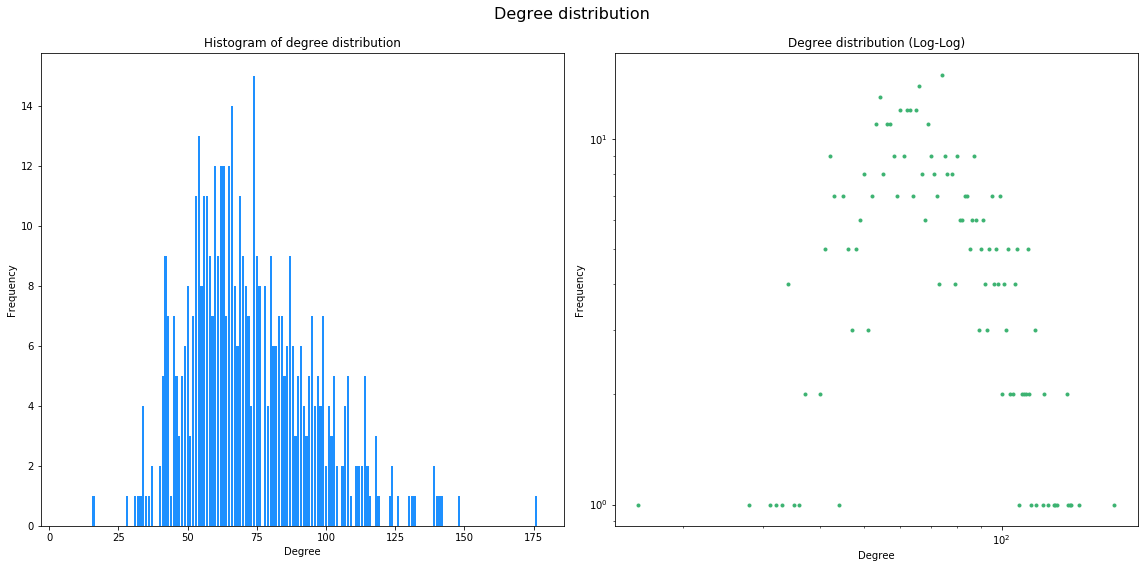

In [22]:
# Plot:
fig, axarr = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle("Degree distribution", fontsize=16)

axarr[0].bar(deg,cnt,color='dodgerblue')
axarr[0].set_xlabel('Degree')
axarr[0].set_ylabel("Frequency")
axarr[0].set_xlim([-3,max(deg)+10])
axarr[0].set_title("Histogram of degree distribution")

axarr[1].loglog(bin_edges[:-1],hist,'.', color="mediumseagreen")
axarr[1].set_xlabel('Degree')
axarr[1].set_ylabel("Frequency")
axarr[1].set_title("Degree distribution (Log-Log)")

fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [40]:
# Reverse lookup for speed increase
reverse_movie_year_lookup={}
for row in df.iterrows():
    if pd.isna(row[1]['release_date']):
        continue
    reverse_movie_year_lookup[row[1]['original_title']] = row[1]['release_date']

#Extract data
relase_data = []
for node in G.nodes:
    actor_movies = sorted([reverse_movie_year_lookup[x].year for x in G.nodes[node]['movies']])
    first_release = min(actor_movies)
    actor_movies = [x-first_release for x in actor_movies]
    relase_data.append((node, actor_movies, [x for x in range(1,len(actor_movies)+1)]))
    
    

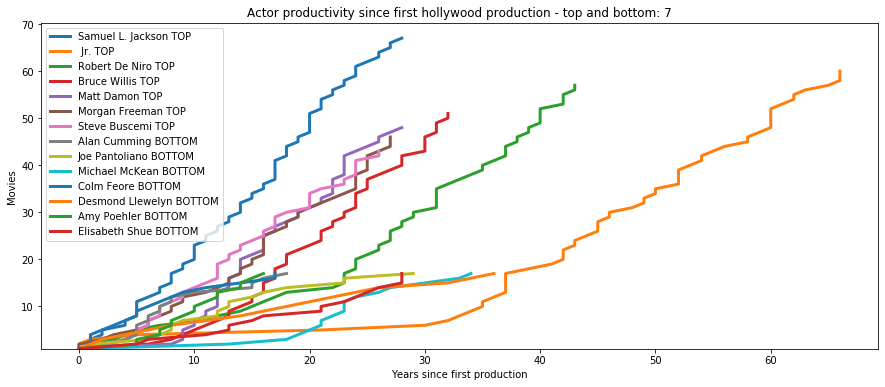

In [42]:
limit=7
l_relase_data=len(relase_data)
relase_data=sorted(relase_data, key=lambda x: len(x[1]), reverse=True)[0:limit]+sorted(relase_data, key=lambda x: len(x[1]), reverse=True)[l_relase_data-limit:l_relase_data]
fig, ax = plt.subplots(figsize=(15, 6))
for i in range(len(relase_data)):
    l_postfix=' TOP'
    if i>=limit:
        l_postfix=' BOTTOM'
    ax.plot(relase_data[i][1], relase_data[i][2], label=relase_data[i][0]+l_postfix,linewidth=3)
ax.set_ylim(1)
ax.set_ylabel('Movies')
ax.set_xlabel('Years since first production')
plt.title(f'Actor productivity since first hollywood production - top and bottom: {limit}')
plt.legend()
plt.show()

In [43]:
G.edges[('Samuel L. Jackson', 'Robert Downey Jr.')]

{'weight': 4}

This seems to validate our assumption of the network to not follow a powerlaw distribution. The data semmes normal distributed around 65 with a slight right skewness, though not completely. This would follow the intuition that a few actors a working on the majority of the feature films. The plot of actor productivity seems to tell a bit different story, that even between the top 500 Actors tgere are quite a big diffenrence in productivity between the top and bottom.

Relating this to the movies industry we also know that some actors can produce very large amount in a short time without great imdb scores where as others work on slower productions with a higher focus on production values

Lets take a look at visual representation of the network

In [44]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0.6,

                        # Performance
                        jitterTolerance=0.15,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.7,

                        # Tuning
                        scalingRatio=4.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)

In [184]:
@gif.frame
def plot_graph(G):
    color_map = {}
    for genre in list(set([G.node[x]['top_genre'] for x in list(G.nodes)])):
        color_map[genre] = []

    for node in G.nodes:
        color_map[G.node[node]['top_genre']] += [node]
    fig, ax = plt.subplots(figsize=(16,12))

    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
    
    color = {'Action': 'Red', 'Adventure': 'Blue', 'Animation': 'Pink', 'Comedy': 'Green', 'Crime': 'Brown',\
          'Drama': 'Cyan', 'Family': 'Yellow', 'Thriller' : 'White', 'Romance': 'Orange', 'Science Fiction': 'Black'}
    
    
    
    for key in color_map.keys():
        nx.draw_networkx_nodes(G,pos=positions,nodelist=color_map[key],\
            node_size=300, node_color=color[key], label=key, ax=ax)
        #[G.degree(y) for y in color_map[key]]
    

    nx.draw_networkx_edges(G, positions, edge_color="grey", alpha=1, ax = ax)
    ax.legend(scatterpoints = 1)
    nx.draw_networkx_labels(G, positions, font_size=14, ax = ax)
    ax.axis('off')
    #ax.set_title('Top 500 Actors \n Colored after most common genre, sized after total feature films')
    return ax

## <span style="color:red">Remove before final version</span>

### Create GIF

In [185]:
gif.options.matplotlib["dpi"] = 800

In [186]:
rand_neighbors = []

for i in range(20):
    n1 = np.random.randint(low = 20, high = 40)
    n2 = np.random.randint(low = 5, high = 8)
    n = list(G.neighbors('Samuel L. Jackson'))[n1:n1+n2] + ['Samuel L. Jackson']
    rand_neighbors += [n]

In [187]:
%%capture
frames = []
for n in rand_neighbors:
    frame = plot_graph(G.subgraph(n))
    frames.append(frame)

In [189]:
gif.save(frames, 'network.gif', duration=40, unit="s", between="startend")

### End GIF

In [71]:
# Plot issues
Image(filename='Figure_1.png') 

TypeError: 'module' object is not callable

From the above plot we see that there seem to be an overweight of actors acting within the genres of Comedy and Drama. 

DOES COMPARISON WITH RANDOM NETWORK WORK? WE ARE IN AN GC

### Changes in the network over time

Introduction to this section


In [28]:
# Has there been a large change in the most popular genre
df.sort_values('release_date', inplace=True)

genres=set([y for x in movie_genre.values() for y in x])
data = defaultdict(lambda: defaultdict(int))

for x in df.iterrows():
    for y in json.loads(x[1]['genres']):
        data[x[1]['release_date'].year][y['name']]+=1
# Set missing values
for k in data.keys():
    missing_k=genres.difference(set( x for x in data[k].keys()))
    for genre in missing_k:
        data[k][genre]=0

<IPython.core.display.Javascript object>


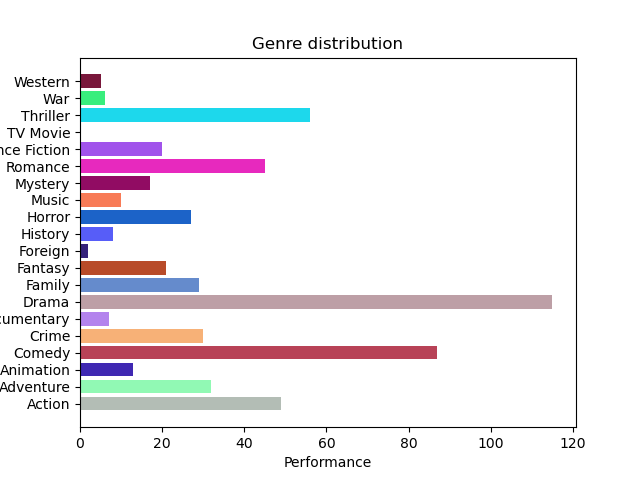

interactive(children=(Dropdown(description='year', options=(1916, 1925, 1927, 1929, 1930, 1932, 1933, 1934, 19…

In [57]:
%matplotlib notebook

np.random.seed(19680801)
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(genres))
# Get names a lazy way
genres_ = [x[0] for x in sorted(data[2000].items())]
colors = np.random.rand(len(genres),3)
ax.set_yticks(y_pos)
ax.set_yticklabels(genres_)
ax.set_xlabel('Performance')
ax.set_title('Genre distribution')


def update(year):
    performance = [x[1] for x in sorted(data[year].items())]
    ax.barh(y_pos, performance, align='center', color=colors)
    time.sleep(0.1)

interact(update, year = data.keys());

**timelapse of genre distribution**

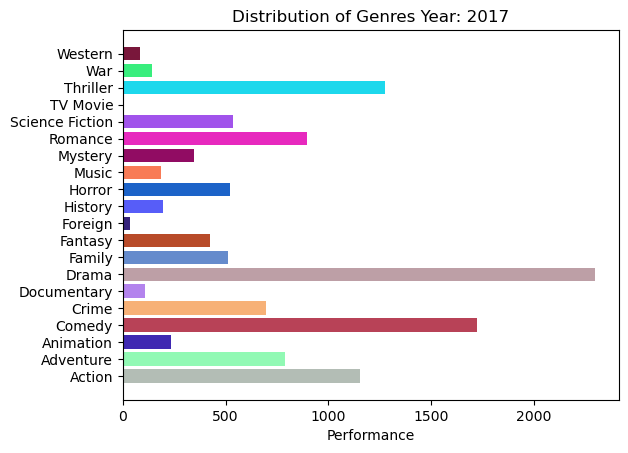

In [89]:
%matplotlib inline
np.random.seed(19680801)
plt.rcdefaults()

cumm=True

# Example data
y_pos = np.arange(len(genres))
colors = np.random.rand(len(genres),3)
#lazy init
labels_=[x[0] for x in sorted(data[2000].items())]

cumm_data=np.zeros(len(labels_))
for year in data.keys():    
    performance = [x[1] for x in sorted(data[year].items())]
    cumm_data+=performance
    if cumm:
        performance=cumm_data
    plt.barh(y_pos, performance, align='center', color=colors)
    plt.xlabel('Performance')
    plt.yticks(y_pos,labels_)
    plt.title(f"Distribution of Genres Year: {year}")
    plt.show()
    time.sleep(0.1)
    clear_output(wait=True)

From the above plot we see INSERT SJEOF OSEJFESJ PJES  AFNEEAFO NESA NOAEFS

#### Patterns of actors work

### Important words of the decade
Now that we have a good idea of how the network has evolved and what genres are the dominant ones lets take the initial steps to look if we can regonize the mood of the times through the TF-IDF for the decades. Does these correspond with the genre distribution? And do we get the same themes plotting the wordclouds for the moives of the decades against what we find from the historical wikipedia pages?

#### TF-IDF calculation
The term TF-IDF is short for term frequency–inverse document frequency[\[2\]](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

TF-IDF is a statistical measure for the importance of a word in a document or corpus. The goal of using this statistical measure is to idetify themes or elements of importance within the identified communities. The expected result is for example some words related to violence and crime to be dominant within the villan community surrounding The Joker


#### Calculation of TF-IDF
The calculation of TF-IDF can be done in many ways. Examples of TF are

>Boolean "frequencies": tf(t,d) = 1 if t occurs in d and 0 otherwise;
term frequency adjusted for document length: tf(t,d) = ft,d ÷ (number of words in d)
logarithmically scaled frequency: tf(t,d) = log (1 + ft,d);
augmented frequency, to prevent a bias towards longer documents\[2\]

Because the document as fairly similiar for all the movies the bare count was choosen as the TF.

For the IDF the $log(1+\frac{N}{1+n_t})$ was choosen, as it is a common choice with the +1 in the denominator ensuring not division by zero and the other +1 ensuring >1 value for the log fuction.

#### Documents and Collections
As mentioned earlier the TF-IDF measure is a measure for a single document in a corpus. The problem has been modelled in the following way:
* The documents $ D $ are the joined overview for the given segmentation - decade in this case 
* The collection $ C $ is the joined documents for all the movies in the  **dataset/corpus** (kan dette siges?)

#### Stopwords
Stopwords contribute very little information and usually gets filtered out through the inverse document frequency, but since the collections is quite small in this case around 8, the IDF penalty for occuring in many documents is simply too small compared to the raw count of the stopwords. To limit problems with this is has been decided to remove the stopwords all together

In [182]:
def load_segmented_documents(dataf, start_year:int, segment_years:int)-> defaultdict:
    document_data = defaultdict(str)
    for x in dataf.iterrows():
        # Skip
        if pd.isna(x[1]['release_date']):
            continue
        # Skip
        if pd.isna(x[1]['overview']):
            continue
        # Skip
        if x[1]['release_date'].year<start_year:
            continue
        y = int(x[1]['release_date'].year/segment_years)*segment_years
        document_data[y]+=(x[1]['overview'])
        dataf.iloc[x[0]]['segment_year']=y
    return document_data

        
def calculate_tf_idf(document: list, collection: list):
    # Tr calculation
    # Naive count
    tf=Counter(document)
    # other variations
    #for k in tr: tr[k] = math.log10(tr[k]+1)
    #for k in tr: tr[k] /= len(document)
    
    # IDF
    N=len(collection)
    # Flattens data
    idf = defaultdict(int)
    for d in collection:
        words = set(d)
        for x in words:
            idf[x]+=1
    
    # Calculate IDF from n and n_t
    for k in idf: idf[k] = math.log(1+ N/(idf[k]+1))
    tfidf={k:tf[k]*idf[k] for k in tf}
    
    return tfidf

def tokenize(text:str, remove_stop_words=True)-> list:
    tokenized = [word.lower() for word in nltk.word_tokenize(text) if word.isalpha()]
    if remove_stop_words:
        stop_words = set(stopwords.words('english'))
        tokenized = [x for x in tokenized if x not in stop_words]
    return tokenized



In [183]:
# Extracting the data
docs=load_segmented_documents(df,1970,10)
collection=[tokenize(v) for v in docs.values()]

tfidf=dict()
for year_segment, text in docs.items():
    tfidf[year_segment]=calculate_tf_idf(tokenize(text), collection)
    

/Users/admin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/admin/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Lets take a look at the first decade in our list and see what we find and if it relates to a lookup on the internet of that decade

In [222]:
y=[x for x in tfidf.keys()][0]
print(f"The first decade in our data is {y}\n")
top_x=10
print(f"The top {top_x} most important words found by idf are:")
for x in [x[0] for x in sorted(tfidf[1970].items(), key=lambda x: x[1], reverse=True)[0:top_x]]:
    print(x)
top_movies=7
print(f"\nThe top {top_movies} grossing movies this decade was:")
df['decade']=df['release_date'].apply(lambda x: int(x.year/10)*10 if not pd.isna(x) else x)
print(df[df['decade']==y].sort_values('budget',ascending=False)[['original_title','budget']][0:top_movies])
print(f"\nThe top {top_movies} rated movies this decade was:")
print(df[df['decade']==y].sort_values('vote_average',ascending=False)[['original_title','vote_average']][0:top_movies])

The first decade in our data is 1970

The top 10 most important words found by idf are:
war
world
one
new
group
young
love
patton
corleone
find

The top 7 grossing movies this decade was:
                     original_title    budget
813                        Superman  55000000
1367  Star Trek: The Motion Picture  35000000
1403             The Bad News Bears  35000000
1510                           1941  35000000
1531                      Moonraker  34000000
1525                 Apocalypse Now  31500000
1877              Tora! Tora! Tora!  25485000

The top 7 rated movies this decade was:
                       original_title  vote_average
3337                    The Godfather           8.4
2731           The Godfather: Part II           8.3
3719  One Flew Over the Cuckoo's Nest           8.2
2912                        Star Wars           8.1
4337                      Taxi Driver           8.0
1525                   Apocalypse Now           8.0
3158                            Alien  

In [289]:
def plot_decade_from_tfidf(year:int, tfidf:dict, top_x_words=100):
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")
    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    plt.figure(figsize=[12,12])
    plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.show()

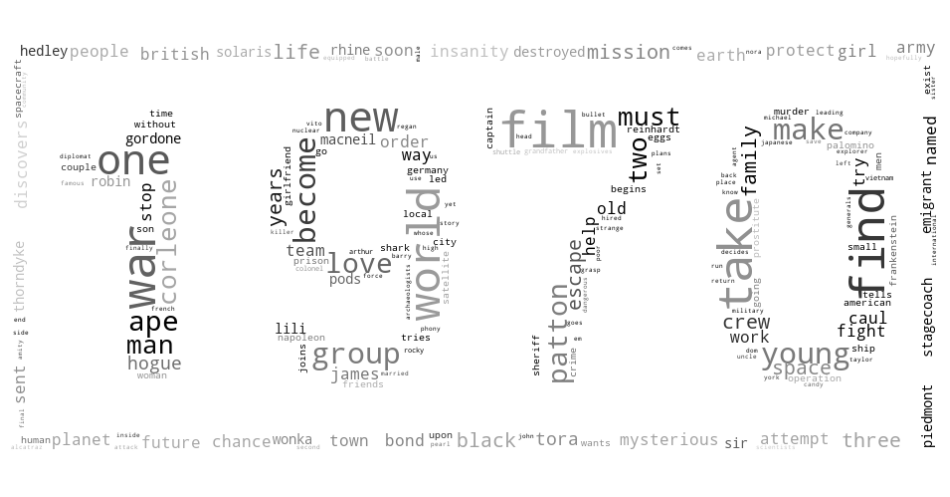

In [290]:
plot_decade_from_tfidf(y, tfidf, top_x_words=200)

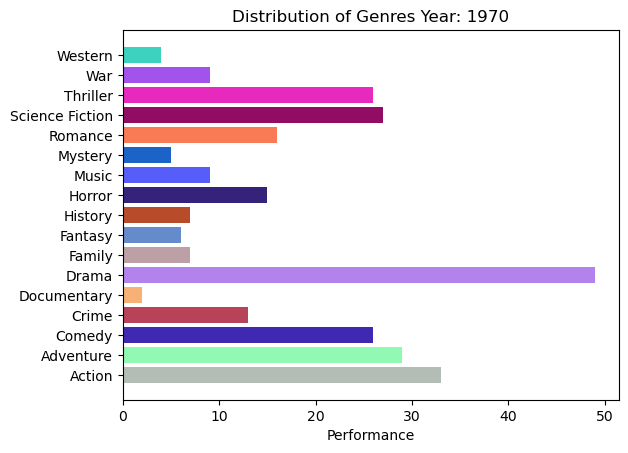

In [315]:
data = sorted(Counter([z['name'] for x in df[df['decade']==y]['genres'] for z in json.loads(x)]).items())
%matplotlib inline
np.random.seed(19680801)
plt.rcdefaults()
y_pos = np.arange(len(data))
colors = np.random.rand(len(genres),3)
#lazy init
labels_=[x[0] for x in data]


performance = np.array([x[1] for x in data])
plt.barh(y_pos, performance, align='center', color=colors)
plt.xlabel('Performance')
plt.yticks(y_pos,labels_)
plt.title(f"Distribution of Genres Year: {y}")
plt.show()

Do analysis on this

How was the 70's in the United states?

Can we related this to what's seen above

### <span style="color:red">Sentiment - copied from comparison section REFACTOR</span>

### Sentiment of the decade
Now we have seen what words are important throught the TF-IDF analysis of the decades. Furthermore, we have gotten and idea of what happens in the world during this time compared to other decades. This was done through the comparison with the globas wiki-pages. **Here we espacially notices INSERT KEY POINTS**. It seems like there could be a correlation between the state of the world an the productions of Hollywood. To dig even further in this we will now take a look at the sentiment of the words. To put it in more general terms: If the world is in bad shape, do hollywood the produce more depressing/sad content?

This section we perform sentiment analysis on the wikipedia data and movie description and relate them to the project hypotesis
**INSERT DEFINITION OF SENTIMENT AND ORIGIN OF DATA ETC. REF TWITTER ARTICLE**


##### <span style="color:red">ADDITIONAL ADDITION</span>


#### Important decision about calculation 
Two important decision:

**Not using a lemmatizer**

The project avoids using a lemmatizer because words such as "armed" or "arm", which are stemmed to the samen word, does not have the same meaning nor the same sentiment associated to it. The same argument goes for words that are stemmed to be equal (part of lemmatization: "have" and "had" can have different sentiments.

In relation to the consideration on whether to remove stop words, the course assignment 2[REF](www.githubrepo) revealed that some stop words are non-neutral, and thus the project won't remove stop words from the texts.

A neutral word has a score of 5, and as stated in the article **Temporal Patterns of Happiness and Information in a Global Social Network[\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752)**, it makes sense to get rid of all the neutral words, because they don't say anything about the happiness of a text. Thus we remove all words with a happiness average smaller than 6 and larger than 4.
This means we choose $\Delta h_{avg} = 1$, and remove all words that lies $h_{avg}$ within the neutral score of 5, that is, $5-h_{avg}<h_{avg}<5+h_{avg}$.

Additionally preperation
* all words in the texts are set to lower case

We will start out by creating the foundation for the sentimentanalysis by loading in the data set from the supplemntary material in [\[3\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752). And filter the data accordin to the described method above

In [359]:
df_s = pd.read_csv('datas1.txt', sep="\t", header=None)
df_s.columns = ["word", "happiness_rank", "happiness_average", "happiness_standard_deviation", "twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]
df_s = df_s[1:]
df_s[["happiness_average", "happiness_standard_deviation"]] = df_s[["happiness_average", "happiness_standard_deviation"]].apply(pd.to_numeric)
df_s = df_s[(df_s['happiness_average']>6) | (df_s['happiness_average']<4)]

In [354]:
df_s

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
1,laughter,1,8.50,0.9313,3600,--,--,1728
2,happiness,2,8.44,0.9723,1853,2458,--,1230
3,love,3,8.42,1.1082,25,317,328,23
4,happy,4,8.30,0.9949,65,1372,1313,375
5,laughed,5,8.26,1.1572,3334,3542,--,2332
...,...,...,...,...,...,...,...,...
10218,murder,10218,1.48,1.0150,2762,3110,1541,1059
10219,terrorism,10219,1.48,0.9089,--,--,3192,--
10220,rape,10220,1.44,0.7866,3133,--,4115,2977
10221,suicide,10221,1.30,0.8391,2124,4707,3319,2107


Now that the data is loaded in, the following formula can be used to calculate the sentiment, for every decade wiki-page and the corresponding movie overview

$$V_{text} = \frac{\sum \limits_k v_k f_k}{\sum \limits_k f_k}$$

#### <span style="color:red">ADDITIONAL INFORMATION - WHY DESCRIPTION OF ELEMENTS IN FORMULA ETC.</span>


As before we will take a look at a specific year again and take a look at it in depth, after wich we will aggregate the findings to more general level using all the segments (decades). The findings will then be discussed

In [ ]:
def calculate_sentiment_dict(text_dict: dict):
    sentiment_dict = defaultdict(list)
    sentiment_dict_aggregate = {}
    words = list(df_s['word'])
    for year, text in text_dict.items():
        # Check if word in df_s if it is get happiness_average
        _temp = [(word.lower(),df_s[df_s['word']==word.lower()]['happiness_average'].values[0]) for word in text if not df_s[df_s['word']==word.lower()]['happiness_average'].empty]
        # Empty list
        if not _temp:
            continue
        sentiment_dict[year]=_temp
        dc = [x[0] for x in sentiment_dict[year]]
        word_count = nltk.FreqDist(dc).most_common()
        words = 0
        happy_score = 0
        for i in range(len(word_count)):
            words += word_count[i][1]
            happy_score += df_s['happiness_average'][df_s['word'] == word_count[i][0]].values[0]*word_count[i][1]
        v_text = happy_score/words
        sentiment_dict_aggregate[year]=v_text
    return sentiment_dict_aggregate, sentiment_dict

In [498]:
# Calculate sentiment for documents
sentiment_wiki_dict_aggregate, sentiment_wiki_dict = calculate_sentiment_dict(wiki_data)
decade_data = {k: tokenize(v) for k,v in docs.items()}
sentiment_decade_dict_aggregate, sentiment_decade_dict = calculate_sentiment_dict(decade_data)

KeyboardInterrupt: 

In [431]:
sentiment_decade_dict_aggregate, sentiment_decade_dict = calculate_sentiment_dict(decade_data)

We now have the calculations of sentiment from the decade segmentation of the movie industry and the wikipedia pages, but how do they relate to eachother and can we relate the sentiment to what we found in the word analysis?

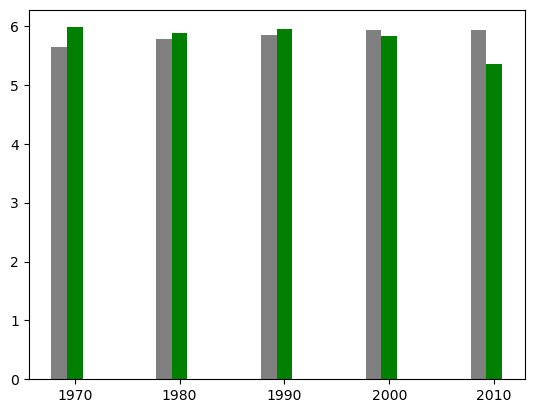

In [442]:
x=np.array(list(sentiment_decade_dict_aggregate.keys()))
y=list(sentiment_decade_dict_aggregate.values())
z=list(sentiment_wiki_dict_aggregate.values())
plt.bar(x-1.5, y, width=1.5, color='grey', align='center', label='wiki')
plt.bar(x, z, width=1.5, color='g', align='center')
plt.show()

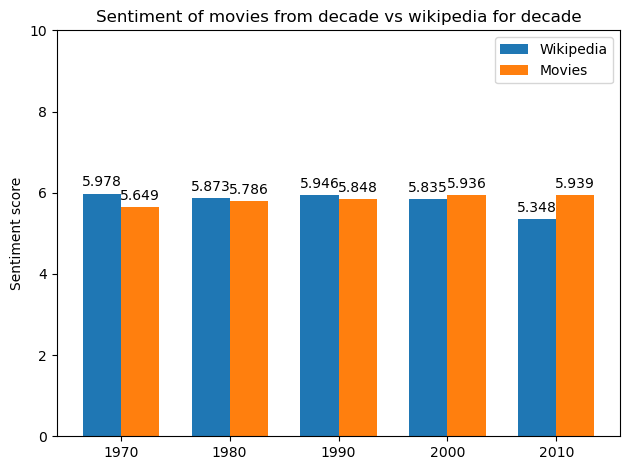

In [449]:
labels = list(sentiment_decade_dict_aggregate.keys())
movies = [round(x,3) for x in list(sentiment_decade_dict_aggregate.values())]
wiki = [round(x,3) for x in list(sentiment_wiki_dict_aggregate.values())]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, wiki, width, label='Wikipedia')
rects2 = ax.bar(x + width/2, movies, width, label='Movies')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment of movies from decade vs wikipedia for decade')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0,10])
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

From the above plot it seems like hollywood reflect the general state of mind of the world, but as the values are centered aroud a neutral is difficult to make any conclusions on the hypotesis. Combining this with the fact that we notice a fairly even distribution between genres we would also expect that the values would be centered around neutral. What should also be noted is that these text segments for the decades are written in a fairly objective manner and therefore might not include many words that are of significant sentiment. On the other hand it might also be that the short movie describtion simply dosen enough positive- or negatively charged words. This is what we will investigate next

I quick look at the sentiment word-list reveals that the most negatively charged words are about terrorism. The movie Zero Dark Thirty about the hunt for Osama Bin Larden, should then be very negativly charged.

In [465]:
df[df['original_title']=='Zero Dark Thirty']['overview'].values[0]

'A chronicle of the decade-long hunt for al-Qaeda terrorist leader Osama bin Laden after the September 2001 attacks, and his death at the hands of the Navy S.E.A.L. Team 6 in May, 2011.'

In [475]:
# Adapt to function format
zdt={'Zero Dark Thirty':tokenize(df[df['original_title']=='Zero Dark Thirty']['overview'].values[0])}
zdt_agg, zdt_values =calculate_sentiment_dict(zdt)

In [477]:
print(f"Zero Dark Thirty has the sentiment: {round(zdt_agg['Zero Dark Thirty'],3)}")

Zero Dark Thirty has the sentiment: 4.047


Zero dark thirty has a low sentiment, but still not as low as expected. How does the distribution look for all movies in the dataset?

In [487]:
row[1]['overview']

nan

In [489]:
sentiment_all_movies = []
for row in df.iterrows():
    if pd.isna(row[1]['overview']):
        continue
    # Fit format
    _temp = {row[0]:tokenize(row[1]['overview'])}
    agg, val = calculate_sentiment_dict(_temp)
    if agg:
        sentiment_all_movies.append(agg)

Text(4.944444444444445, 0.5, 'Count')

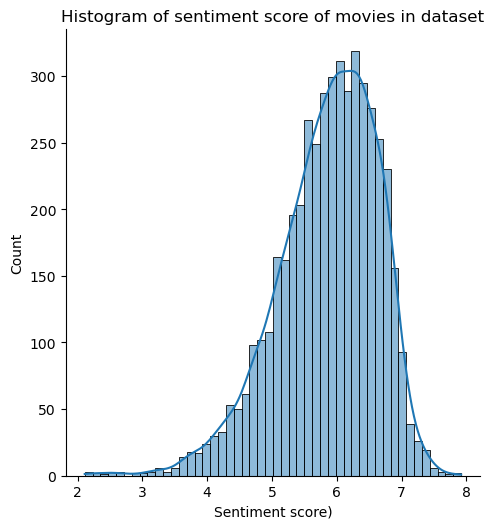

In [497]:
sns.displot([y for x in sentiment_all_movies for y in list(x.values())], kde=True)
plt.title('Histogram of sentiment score of movies in dataset')
plt.xlabel('Sentiment score')
plt.ylabel('Count')

As expected the vas majority is centered around the slight positive sentiment with only few very negative ones

**Splitting on genre** - out of scope?

## Analysis of Actor Communities and Their Sentiment

As presented in project assignment A, we have a hypotesis that there exist small communities within hollywood where groups of actors do the majority of their work together in specific genres. An example could be Denzel Washington which primarly does his work within Action and Drama. Does he always work with alot of the same crew?

To put it in general terms this section will uncover what actors work together, whether they form cliques? What charaterize these communites and a zoom in on specific Actors. 

This will be done through:
* Community detection
    * LIST DETECTION ALGORITHMS
* Important words
    * TF-IDF
    * Wordclouds
    * Lookup of movies
* Sentiment of communities
    * What communities are happy/sad?


In [463]:
df[df['original_title']=='Zero Dark Thirty']['overview'].values

array(['A chronicle of the decade-long hunt for al-Qaeda terrorist leader Osama bin Laden after the September 2001 attacks, and his death at the hands of the Navy S.E.A.L. Team 6 in May, 2011.'],
      dtype=object)

In [458]:
for x in df['original_title']:
    print (x)

Avatar
Pirates of the Caribbean: At World's End
Spectre
The Dark Knight Rises
John Carter
Spider-Man 3
Tangled
Avengers: Age of Ultron
Harry Potter and the Half-Blood Prince
Batman v Superman: Dawn of Justice
Superman Returns
Quantum of Solace
Pirates of the Caribbean: Dead Man's Chest
The Lone Ranger
Man of Steel
The Chronicles of Narnia: Prince Caspian
The Avengers
Pirates of the Caribbean: On Stranger Tides
Men in Black 3
The Hobbit: The Battle of the Five Armies
The Amazing Spider-Man
Robin Hood
The Hobbit: The Desolation of Smaug
The Golden Compass
King Kong
Titanic
Captain America: Civil War
Battleship
Jurassic World
Skyfall
Spider-Man 2
Iron Man 3
Alice in Wonderland
X-Men: The Last Stand
Monsters University
Transformers: Revenge of the Fallen
Transformers: Age of Extinction
Oz: The Great and Powerful
The Amazing Spider-Man 2
TRON: Legacy
Cars 2
Green Lantern
Toy Story 3
Terminator Salvation
Furious 7
World War Z
X-Men: Days of Future Past
Star Trek Into Darkness
Jack the Giant 

30 Minutes or Less
Dracula 2000
Alexander and the Terrible, Horrible, No Good, Very Bad Day
Pride & Prejudice
Blade Runner
Rob Roy
3 Days to Kill
We Own the Night
Lost Souls
Le peuple migrateur
Just My Luck
Mystery, Alaska
The Spy Next Door
A Simple Wish
Ghosts of Mars
Our Brand Is Crisis
Pride and Prejudice and Zombies
Kundun
How to Lose Friends & Alienate People
Kick-Ass 2
Alatriste
Brick Mansions
Octopussy
Knocked Up
My Sister's Keeper
Welcome Home Roscoe Jenkins
A Passage to India
Notes on a Scandal
Rendition
Star Trek VI: The Undiscovered Country
Divine Secrets of the Ya-Ya Sisterhood
Kiss the Girls
The Blues Brothers
The Sisterhood of the Traveling Pants 2
Joyful Noise
About a Boy
Lake Placid
Lucky Number Slevin
The Right Stuff
Anonymous
The Neverending Story
Dark City
The Duchess
Return to Oz
The Newton Boys
Case 39
Suspect Zero
Martian Child
Spy Kids: All the Time in the World
Money Monster
The 51st State
Flawless
Mindhunters
What Just Happened
The Statement
The Magic Flute
Pau

The Haunting in Connecticut 2: Ghosts of Georgia
실미도
Bright Star
My Name Is Khan
All Is Lost
Limbo
Namastey London
The Wind That Shakes the Barley
Yeh Jawaani Hai Deewani
Quo Vadis
Repo! The Genetic Opera
Kurtlar vadisi - Irak
Pulp Fiction
The Muppet Movie
Nightcrawler
Club Dread
The Sound of Music
Splash
Little Miss Sunshine
Stand by Me
28 Days Later
You Got Served
Escape from Alcatraz
Brown Sugar
A Thin Line Between Love and Hate
50/50
Shutter
That Awkward Moment
Modern Problems
Kicks
Much Ado About Nothing
On Her Majesty's Secret Service
New Nightmare
Drive Me Crazy
Akeelah and the Bee
Half Baked
New in Town
American Psycho
The Good Girl
Bon Cop Bad Cop
The Boondock Saints II: All Saints Day
The City of Your Final Destination
Enough Said
Easy A
The Inkwell
Shadow of the Vampire
Prom
The Pallbearer
Held Up
Woman on Top
Howards End
Anomalisa
Another Year
8 femmes
Showdown in Little Tokyo
Clay Pigeons
It's Kind of a Funny Story
Made in Dagenham
And When Did You Last See Your Father?
Pr

The Birth of a Nation
The Work and The Story
Facing the Giants
The Gallows
Eraserhead
Hollywood Shuffle
The Mighty
Penitentiary
The Lost Skeleton of Cadavra
Dude Where's My Dog?
Cheap Thrills
Indie Game: The Movie
Straightheads
Open Secret
Echo Dr.
The Night Visitor
The Past Is a Grotesque Animal
Peace, Propaganda & the Promised Land
Pi
I Love You, Don't Touch Me!
20 Dates
Queen Crab
Super Size Me
The FP
Happy Christmas
The Brain That Wouldn't Die
Tiger Orange
Supporting Characters
Absentia
The Brothers McMullen
The Dirties
Gabriela, Cravo e Canela
Tiny Furniture
Hayride
The Naked Ape
Counting
The Call of Cthulhu
Bending Steel
The Signal
The Image Revolution
This Is Martin Bonner
A True Story
George Washington
Smiling Fish & Goat On Fire
Dawn of the Crescent Moon
Raymond Did It
The Last Waltz
Run, Hide, Die
The Exploding Girl
The Legend of God's Gun
Mutual Appreciation
Her Cry: La Llorona Investigation
Down Terrace
Clerks
Pink Narcissus
Funny Ha Ha
In the Company of Men
Manito
Rampage


## <span style="color:red">Actor communities</span>

Insert data etc.

## <span style="color:red">Actor genre distribution within communities and for communities</span>

Insert data etc.

## <span style="color:red">Section wrap up</span>


Insert data etc.

# <span style="color:red">Analysis part Two Wikipedia</span>
- [ ] <span style="color:red">Introduction to what we whish to acchieve in this section</span>

- [ ] <span style="color:red">Sentiment</span>

- [ ] <span style="color:red">TF-IDF</span>

Every listed element should be written in the following way:

# Wikipedia analysis

### <span style="color:red">Sentiment</span>

In [ ]:
z=list(sentiment_wiki_dict_aggregate.values())

# <span style="color:red">Analysis part Three Bringing it all together</span>


# Comparison of results



### Comparing data tf-idf

In [332]:
# Get wiki data
wiki_data = {}
for year in tfidf.keys():
    wiki_data[year]=tokenize(process_data(look_up_decade(year)))
# All words 
collection = wiki_data.values()

# TF-IDF wiki
tfidf_wiki = {}
for year, text in wiki_data.items():
    tfidf_wiki[year]=calculate_tf_idf(text, collection)


#### Comparing to wikipedia

The above was made based on correlations between internet search and the data found based on our analysis. Now we will introduce the the earlier written wikipedia scraping method for obtaning information 



Most important words ['first', 'decade', 'world', 'united', 'also', 'states', 'war', 'popular', 'john', 'led']


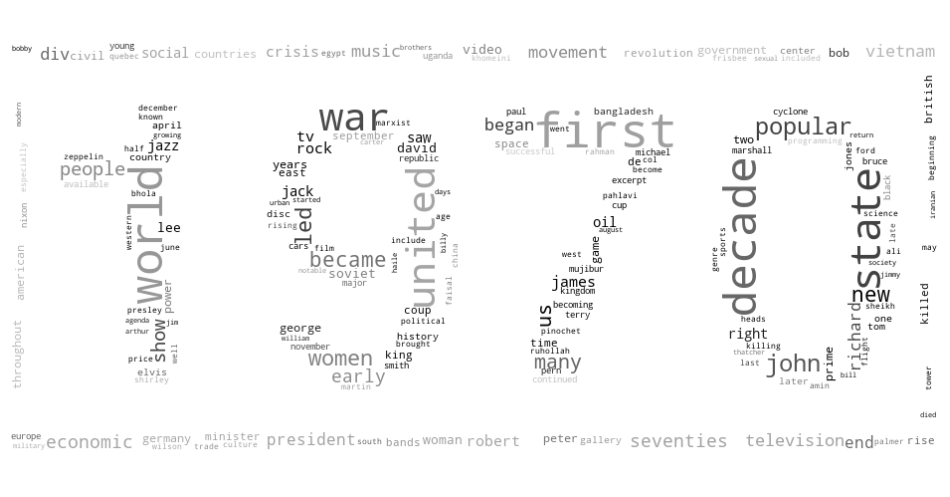

In [338]:
print("Most important words", [x[0] for x in sorted(tfidf_wiki[y].items(), key=lambda x: x[1], reverse=True)[0:10]])
plot_decade_from_tfidf(y, tfidf_wiki, top_x_words=200)

## lets look at the decades together

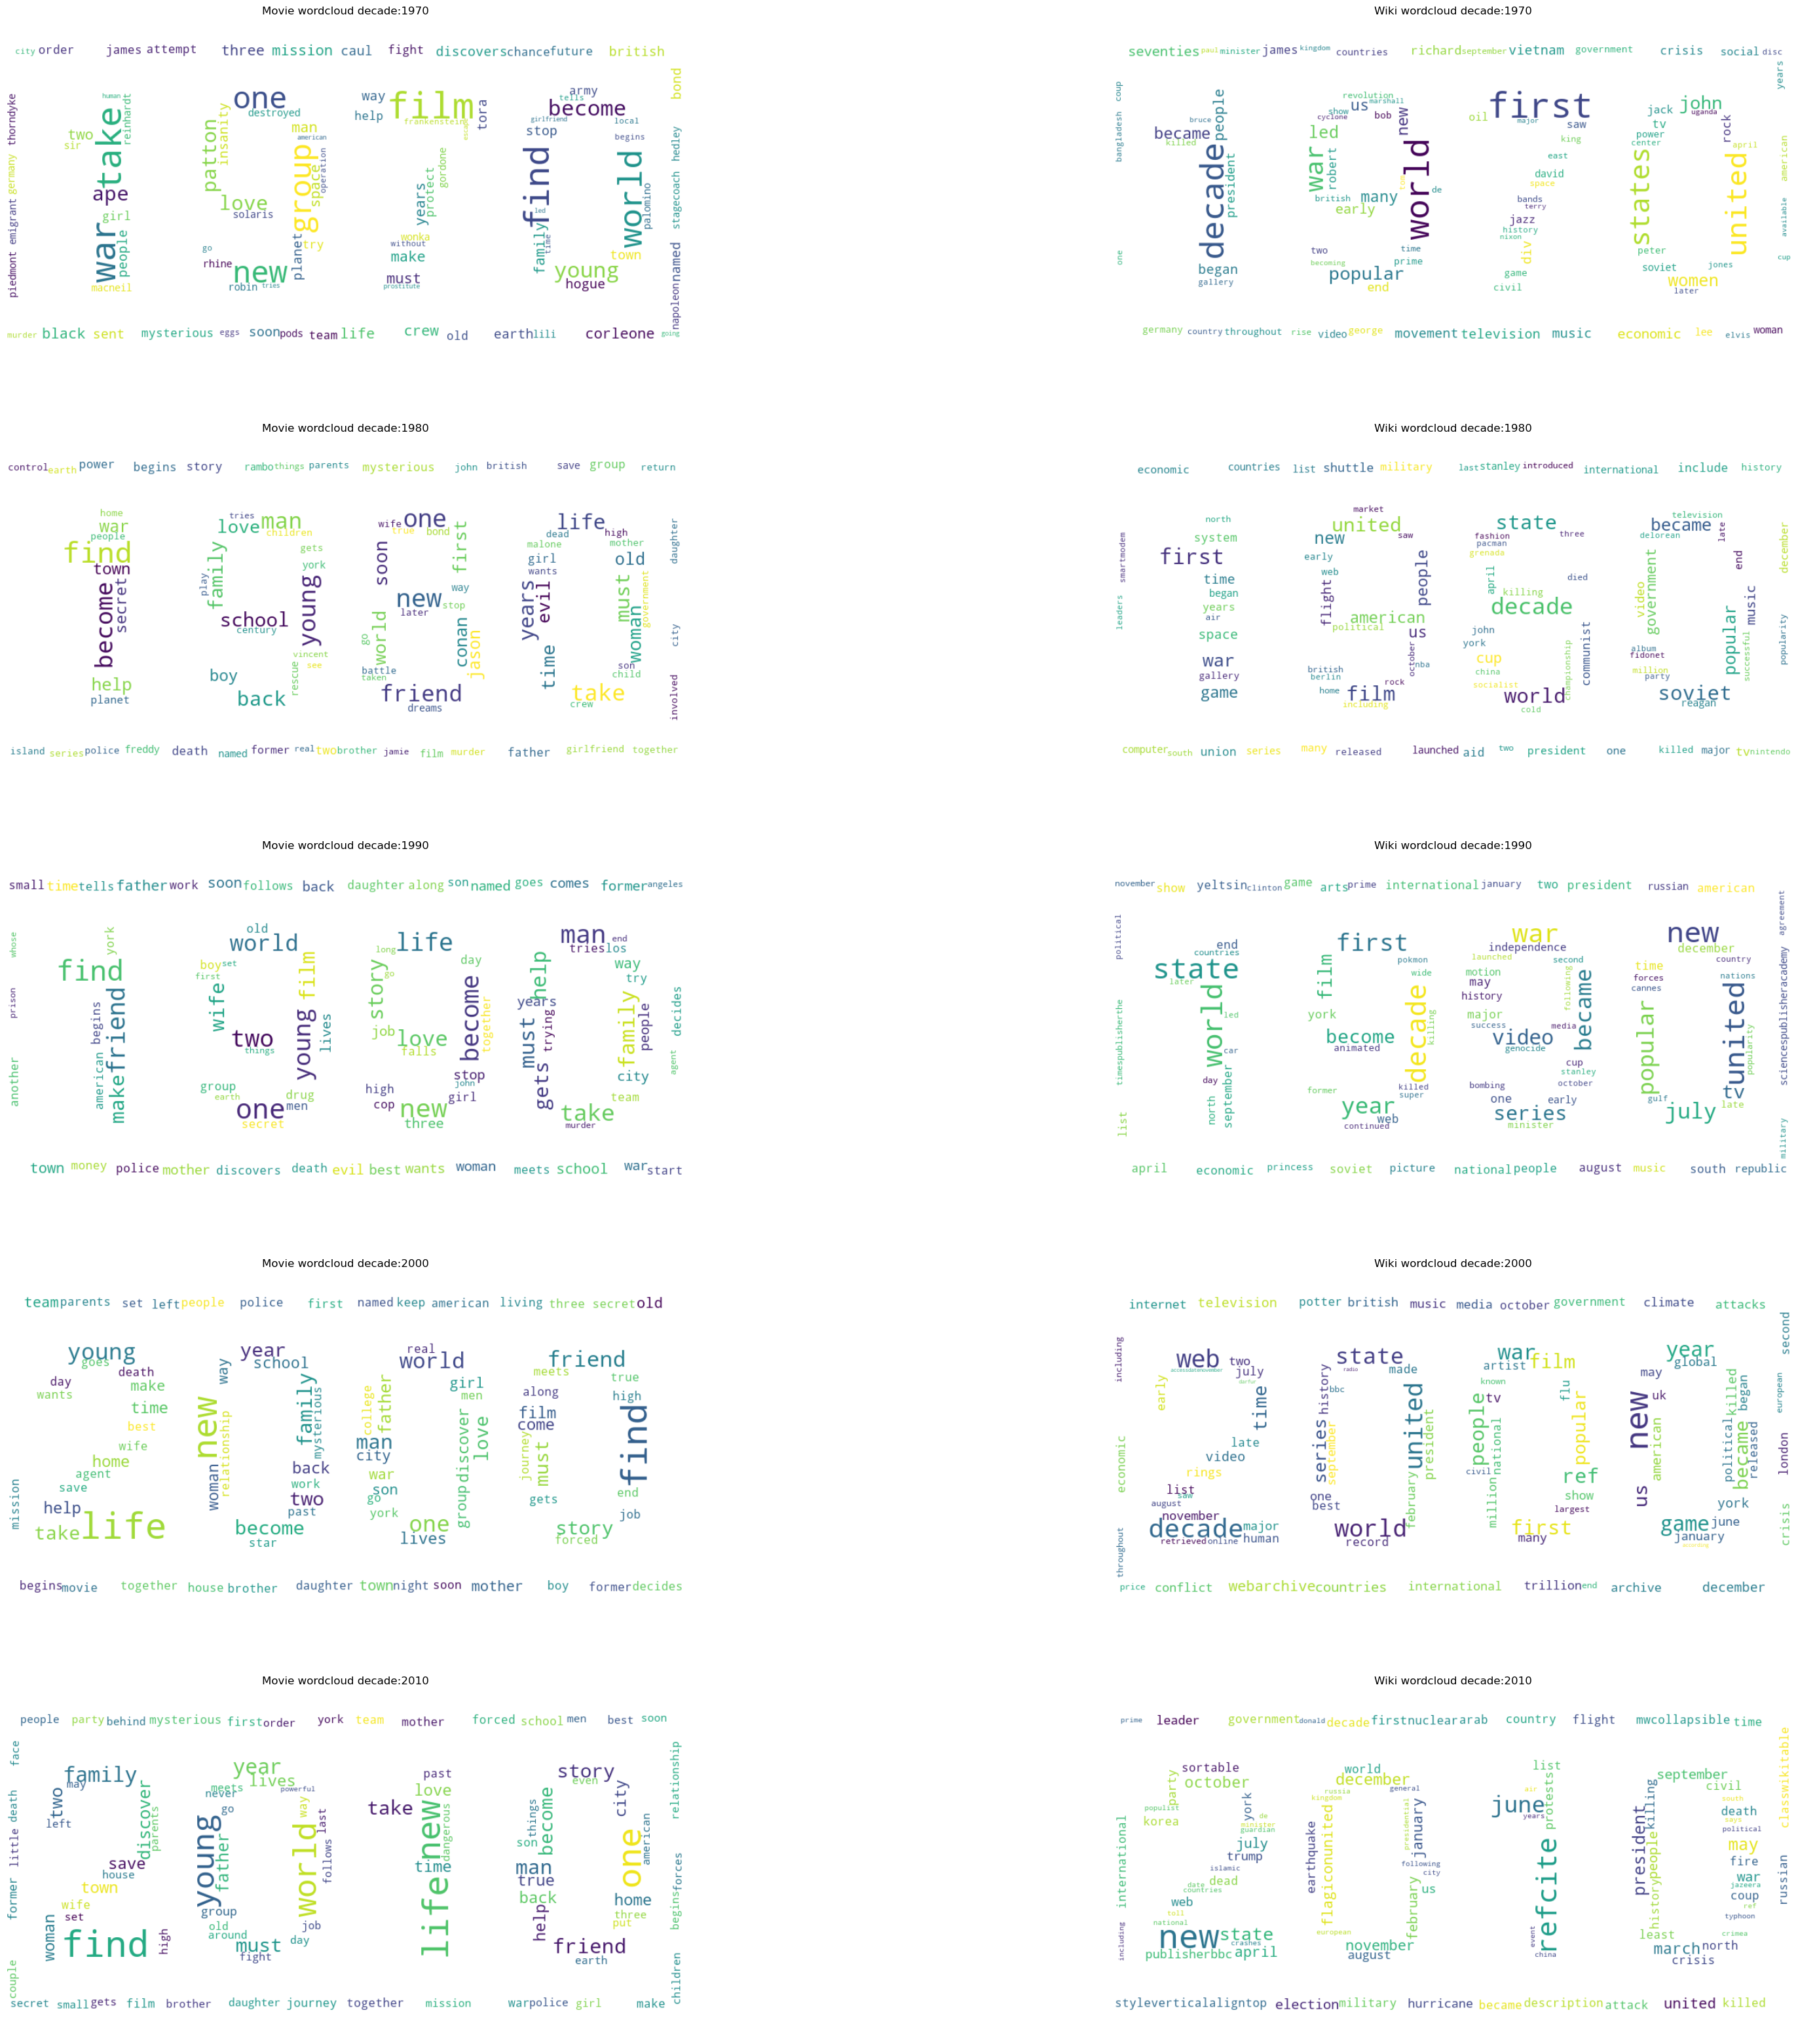

In [344]:
nr=len(tfidf)
nc=2
fig, ax = plt.subplots(nrows=nr,ncols = nc, figsize=(40,40))
idx=0
year_keys = [x for x in tfidf.keys()]
top_words = 200

for i in range(nr):
    year = year_keys[idx]
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    if str(year) not in [x.split('.')[0] for x in os.listdir()]:
        print(f"no mask found for this year{year}")
        raise Exception("Don't use this function")

    mask = np.array(Image.open(f'{year}.png'))
    image_colors = ImageColorGenerator(mask)
    #Movies
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    ax[i][0].imshow(wc, interpolation="bilinear")
    ax[i][0].set_title(f'Movie wordcloud decade:{year}')
    ax[i][0].axis("off")
    
    # Wiki
    text =' '.join([(x[0]+" ")*(int(1+x[1])) for x in sorted(tfidf_wiki[year].items(), key=lambda x: x[1], reverse=True)[0:top_x_words]]).replace('  ',' ')
    wc = WordCloud(collocations=False,background_color="white", max_words=1000, mask=mask).generate(text)
    ax[i][1].imshow(wc, interpolation="bilinear")
    ax[i][1].set_title(f'Wiki wordcloud decade:{year}')
    ax[i][1].axis("off")

    idx+=1
plt.show()

# Discussion of methods and data

I should be noted here that we are working with a quite  small version of the network an